In [18]:
%matplotlib inline
import sys
import helper_functions as hf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.sparse as ssp

hf.set_plot_defaults(fontsize=12)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures

### Load Data

In [19]:
adata = sc.read('210902_PATBROWN_final_filtered_updated.h5ad')

In [20]:
# Normalize to CP10K for plotting
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

adata.raw = adata

### Plot Marker Genes

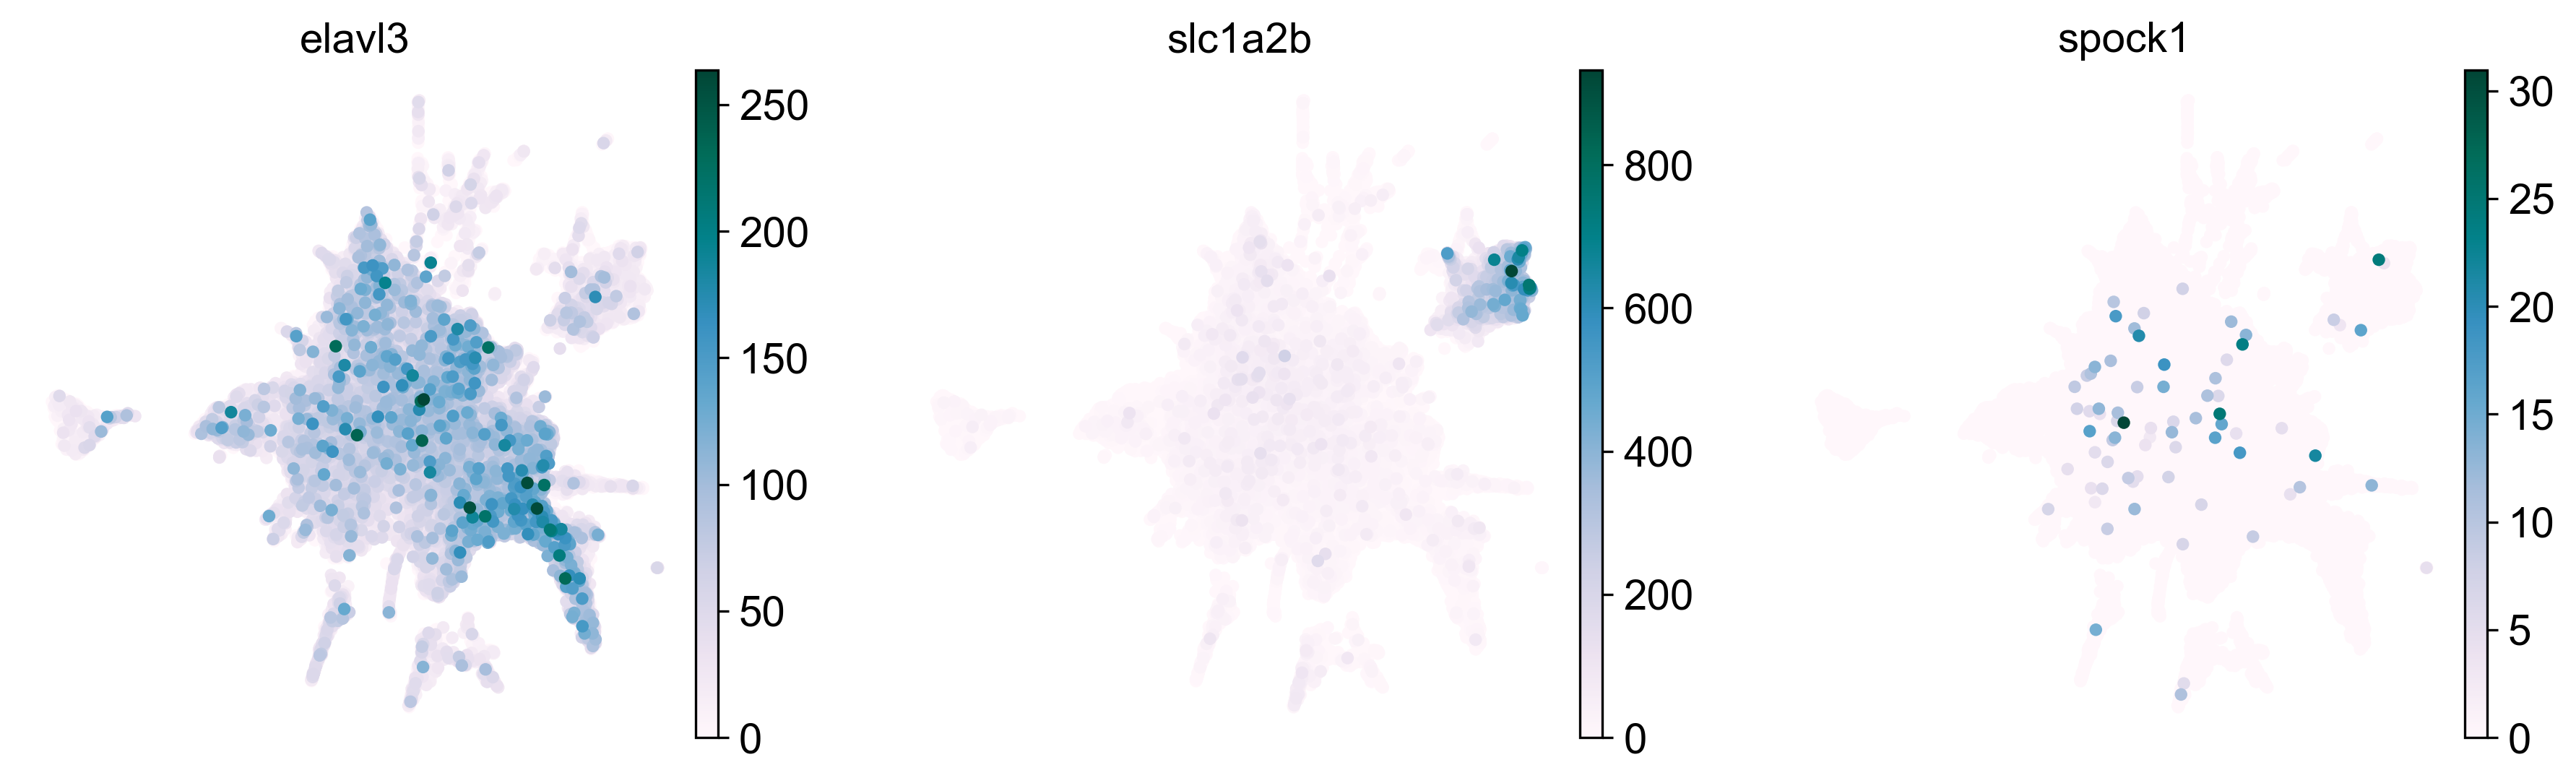

In [21]:
sc.pl.umap(adata, color=['elavl3','slc1a2b','spock1'], size=70, frameon=False, cmap='PuBuGn', save='_Filtered_marker_genes1.pdf')

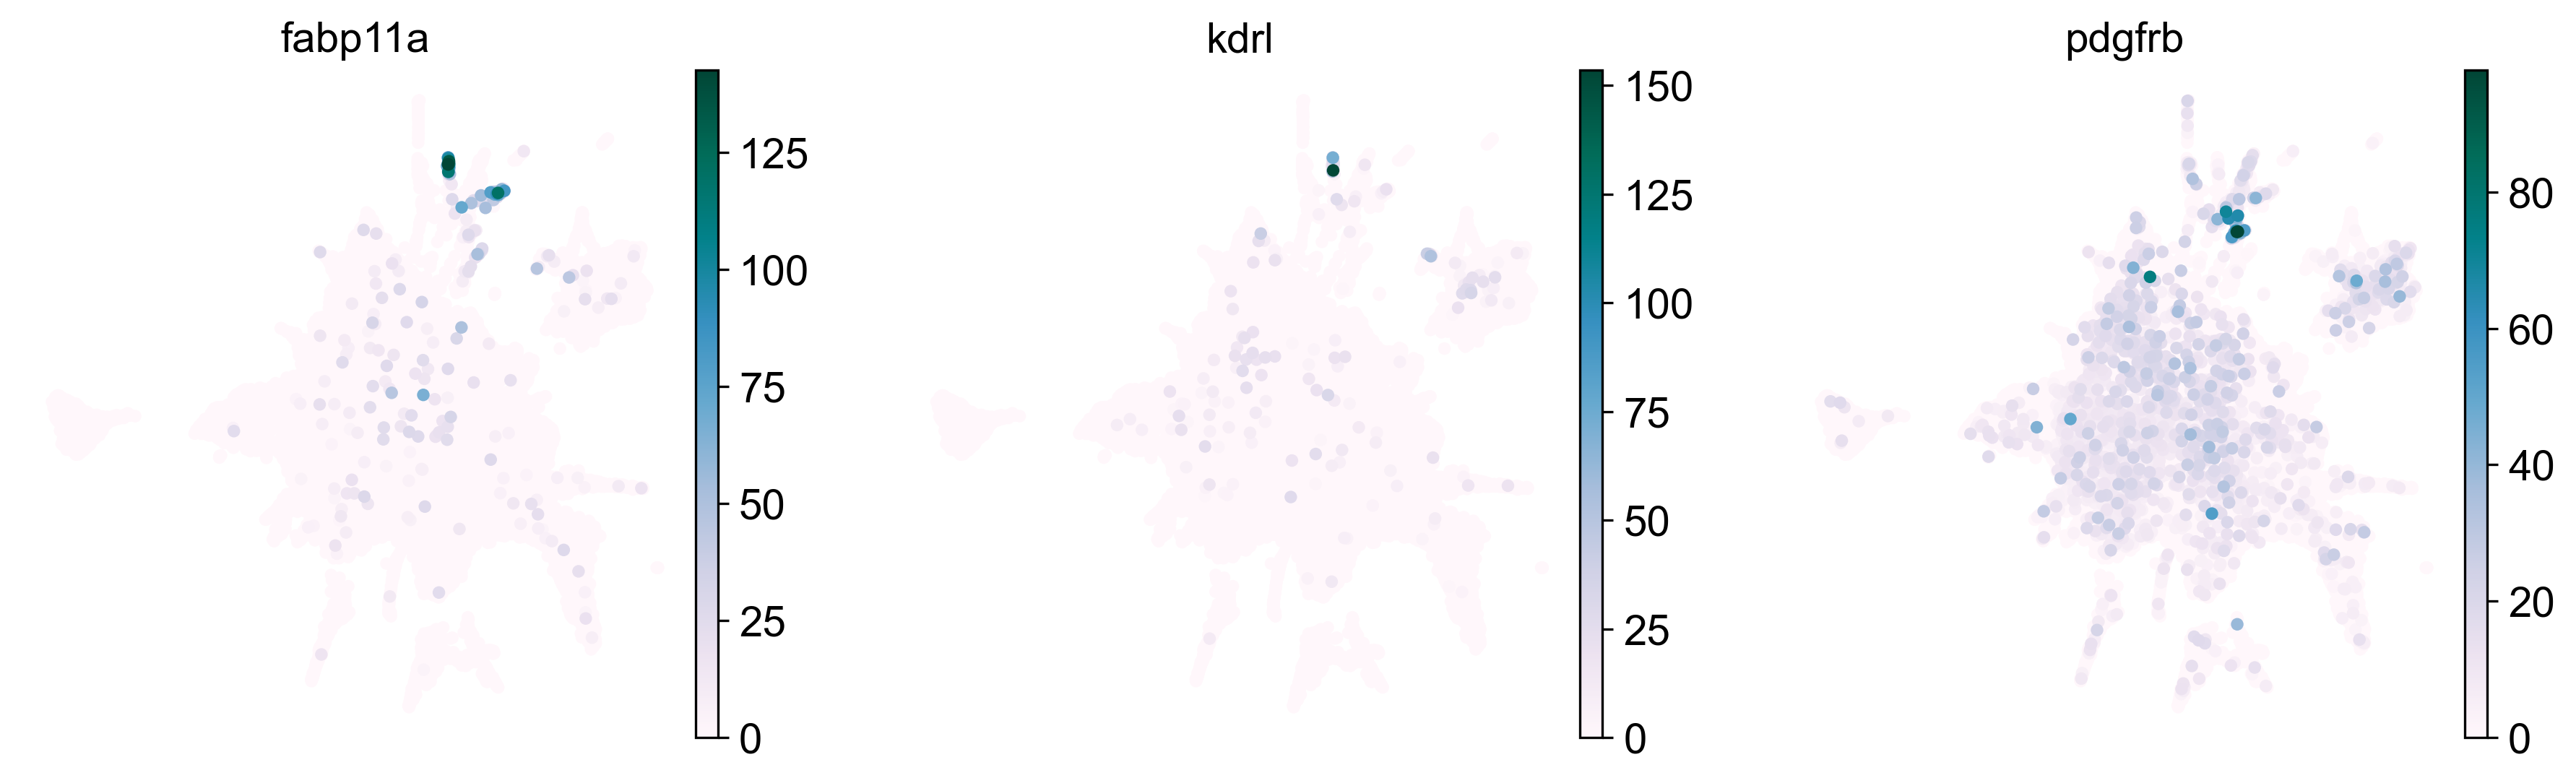

In [22]:
sc.pl.umap(adata, color=['fabp11a','kdrl','pdgfrb'], size=70, frameon=False, cmap='PuBuGn', save='_Filtered_marker_genes2.pdf')


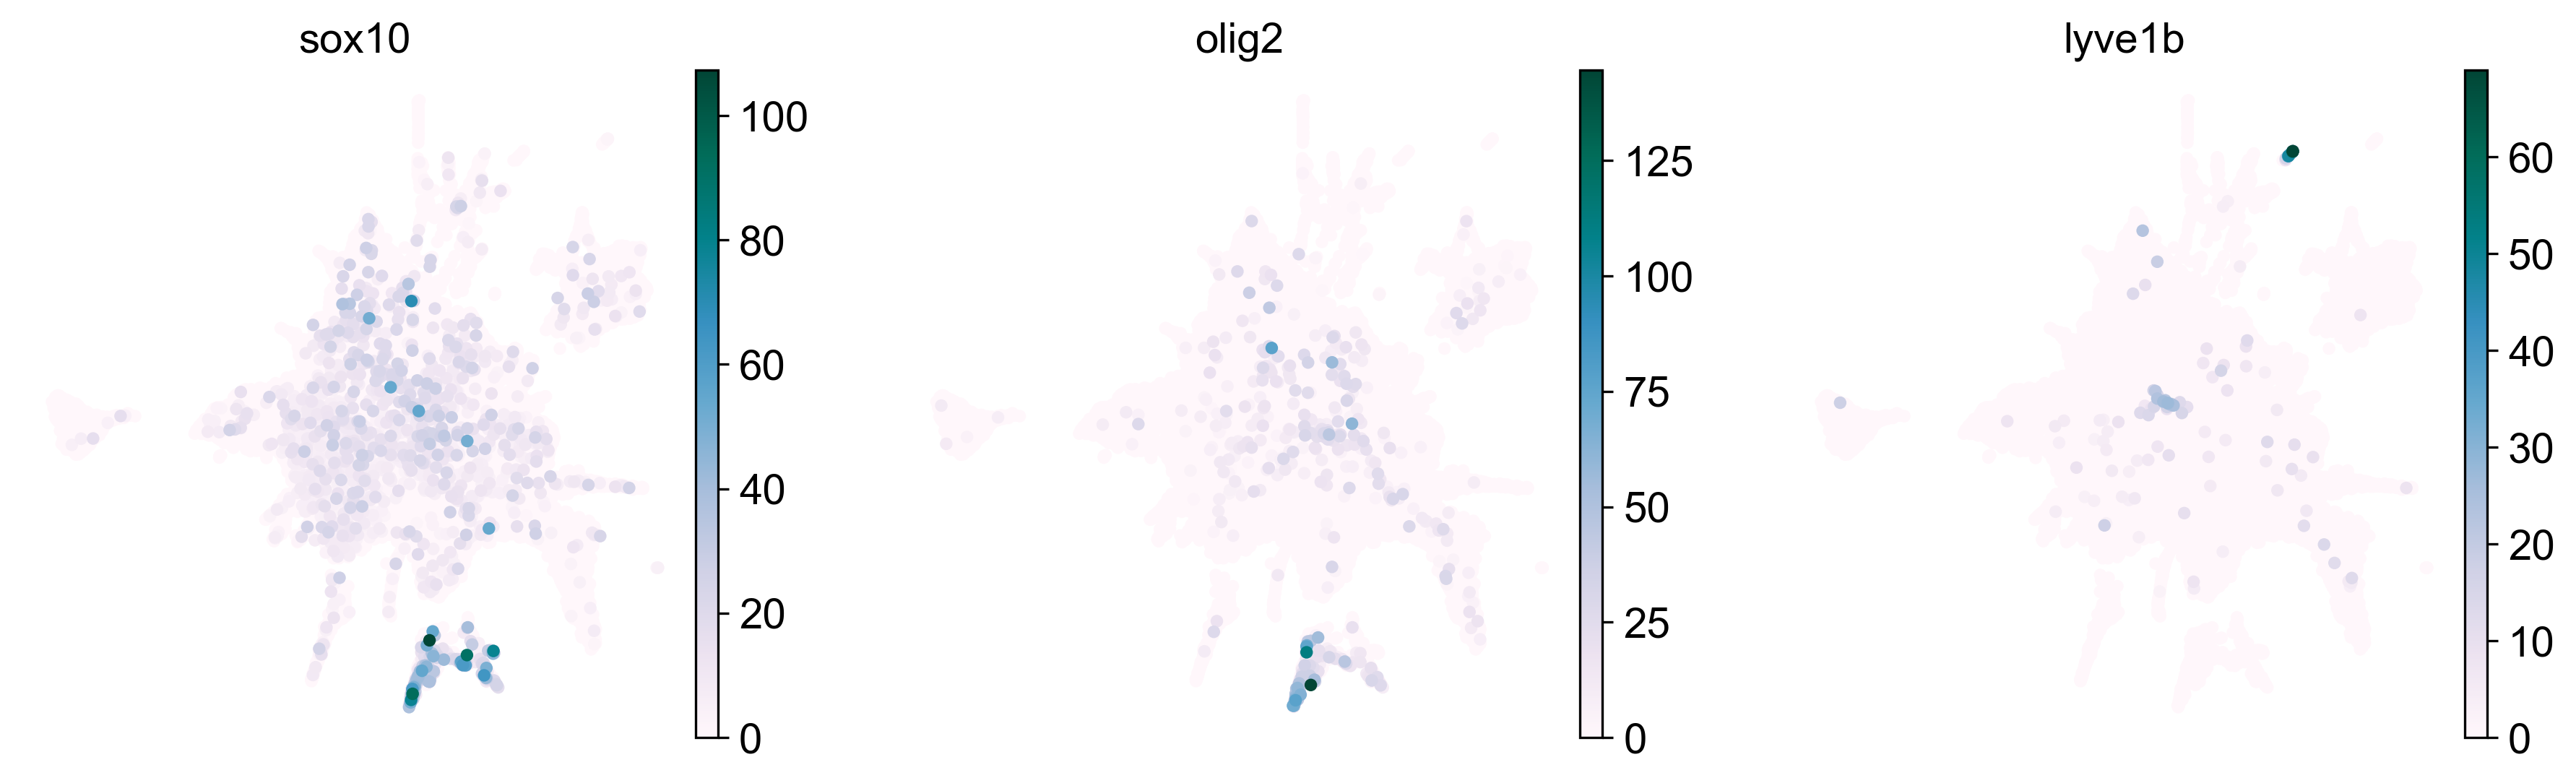

In [23]:
sc.pl.umap(adata, color=['sox10','olig2','lyve1b'], size=70, frameon=False, cmap='PuBuGn', save='_Filtered_marker_genes3.pdf')


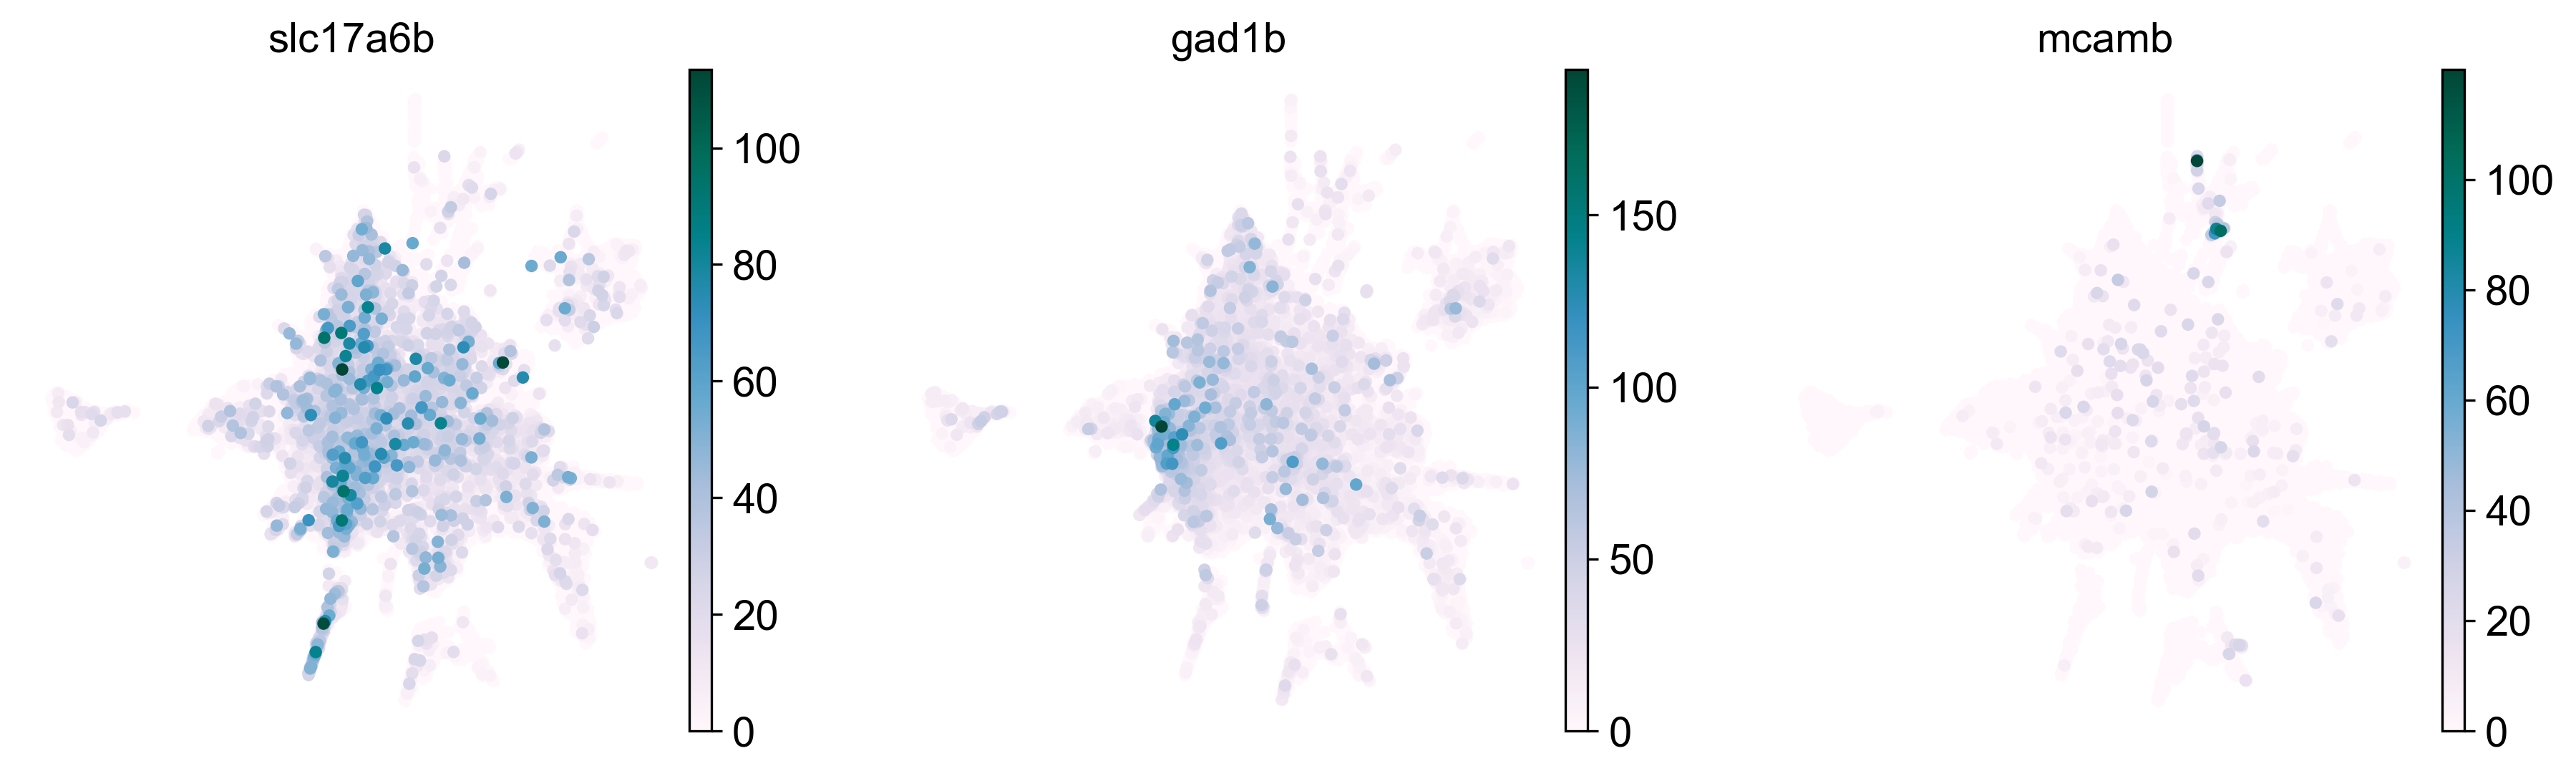

In [24]:
sc.pl.umap(adata, color=['slc17a6b','gad1b','mcamb'], size=70, frameon=False, cmap='PuBuGn', save='_Filtered_marker_genes4.pdf')

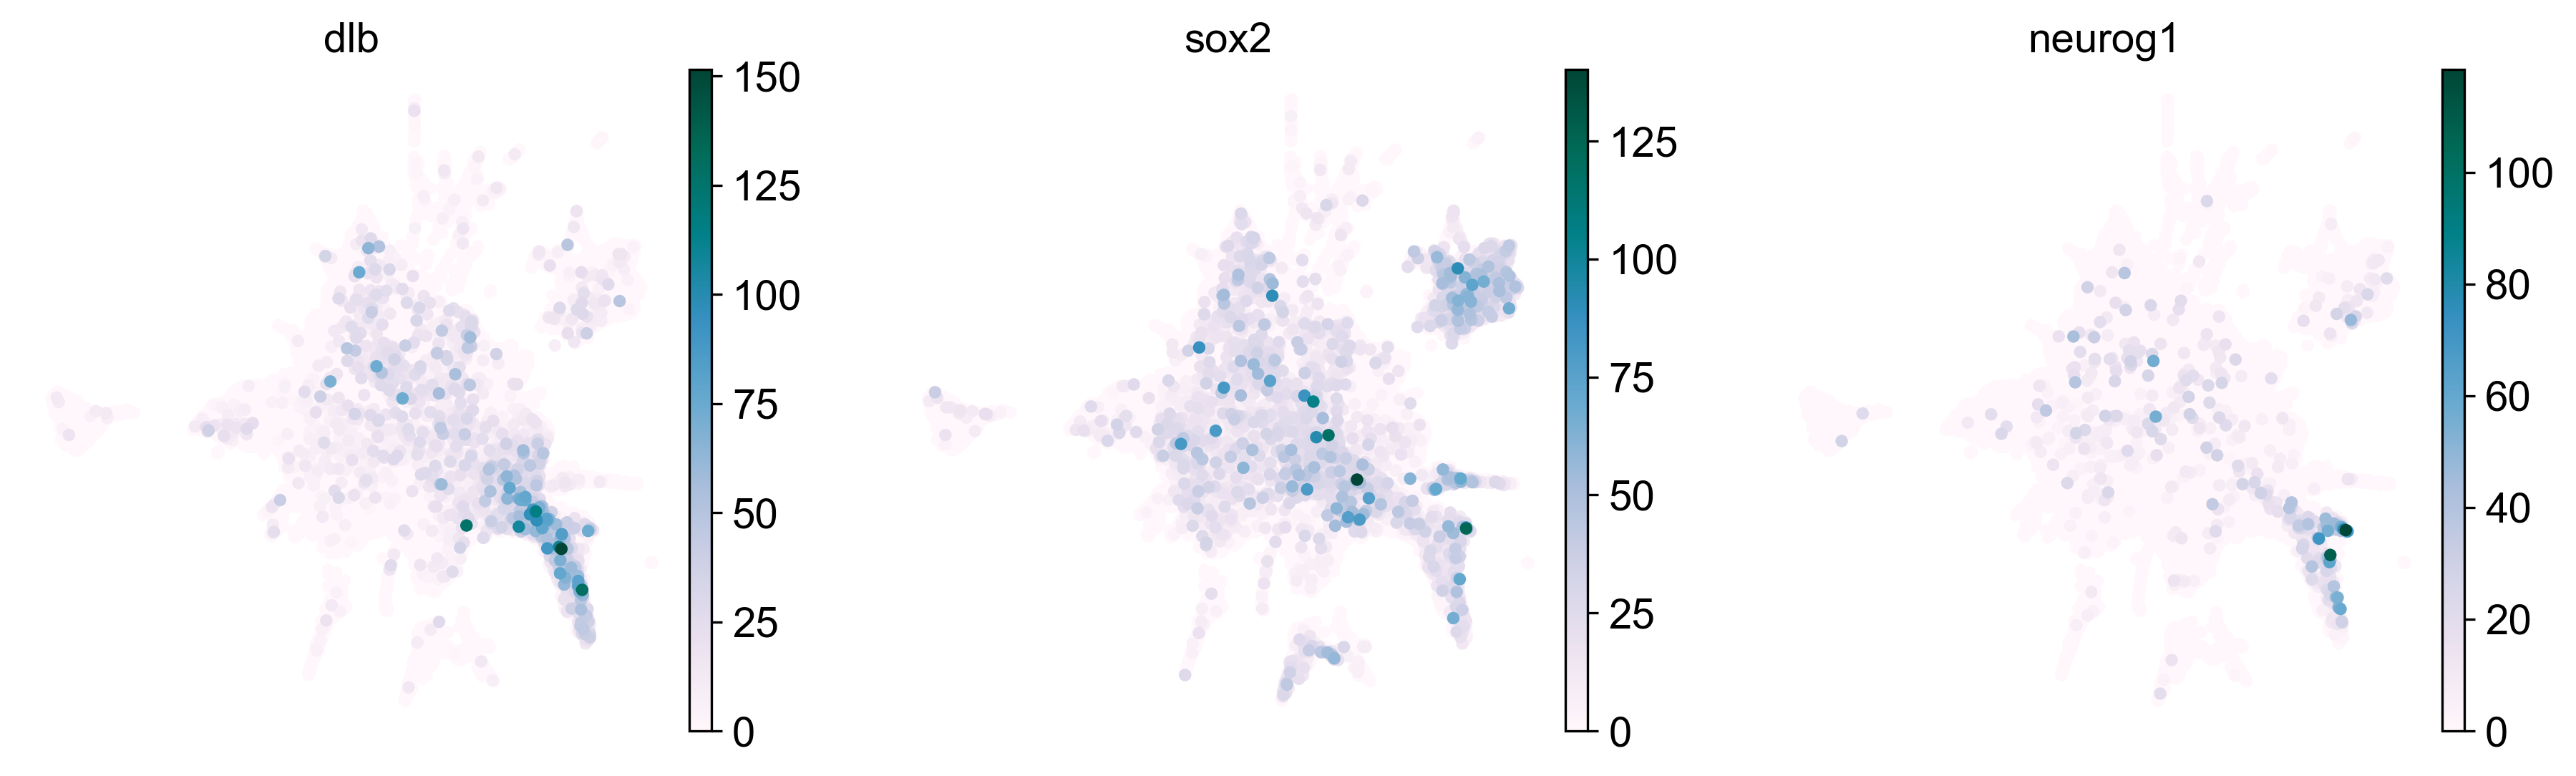

In [25]:
sc.pl.umap(adata, color=['dlb','sox2','neurog1'], size=70, frameon=False, cmap='PuBuGn', save='_Filtered_marker_genes5.pdf')

### Plot genotypes

In [26]:
adata.obs['genotype_comb'] = 'none'
adata.obs['genotype_comb'][adata.obs['genotype'].isin(['AB','RNF'])] = 'WT'
adata.obs['genotype_comb'][adata.obs['genotype'].isin(['mutSpock1'])] = 'mutSpock1'

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/Applications/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genotype_comb' as categorical


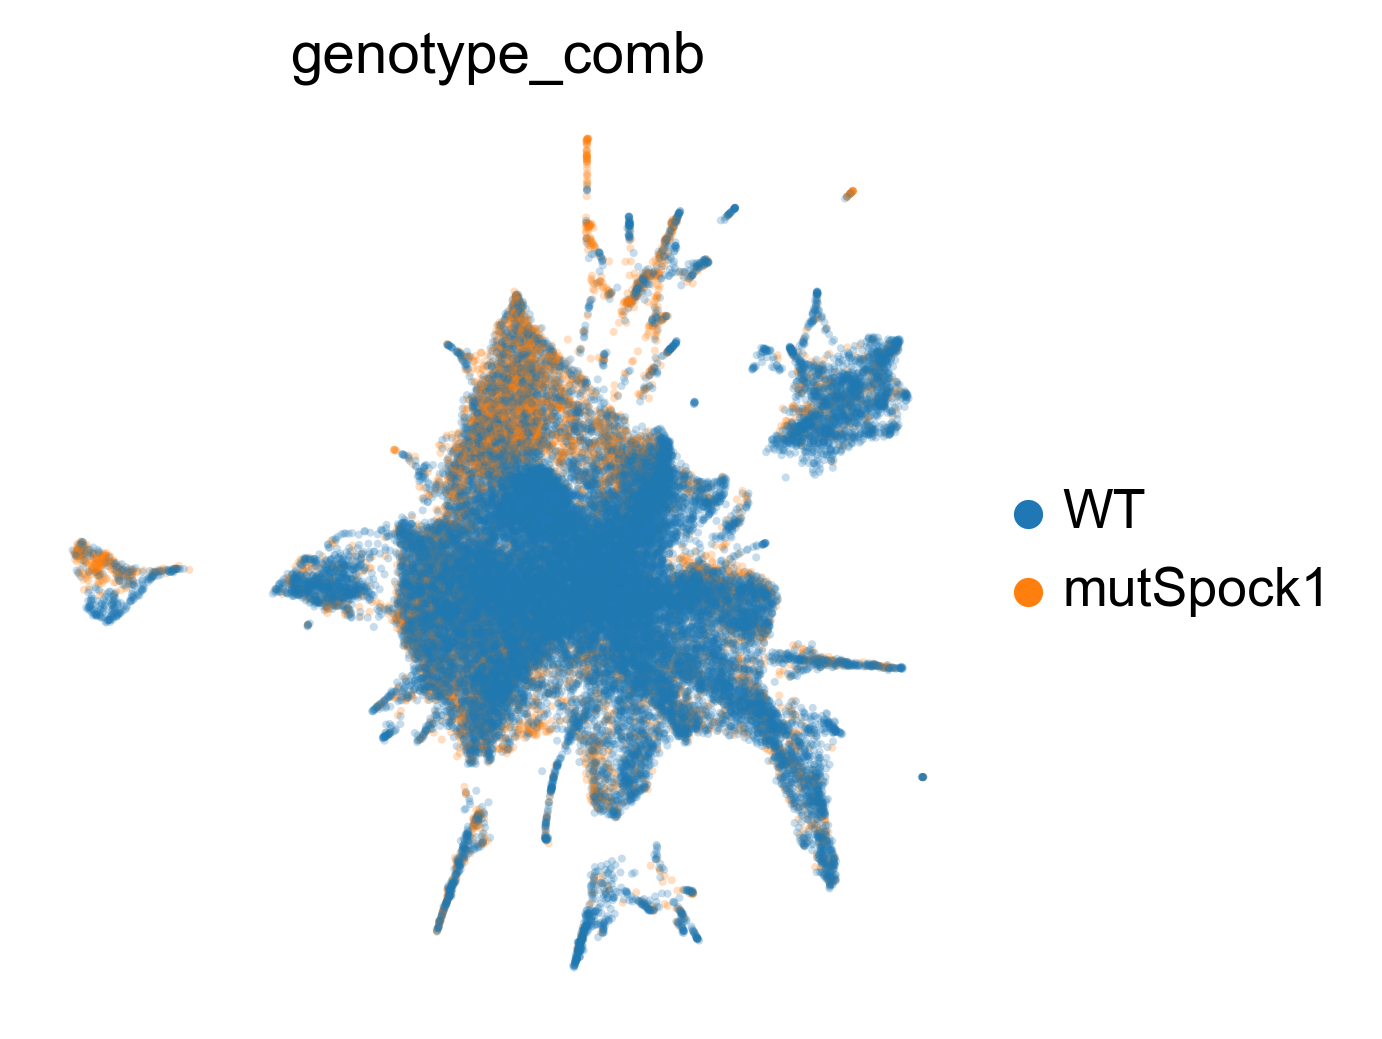

In [27]:
sc.pl.umap(adata, color='genotype_comb', size=15, alpha=0.25, frameon=False, save='_Filtered_genotype2.pdf')

### Plot genotypes on separate plots

In [28]:
# Change genotype colors
adata.uns['genotype_comb_colors'] = ['#333333', '#FF00FF']

In [29]:
def cluster_small_multiples(adata, clust_key, size=60, frameon=False, legend_loc=None, **kwargs):
    tmp = adata.copy()

    for i,clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype('category')
        tmp.uns[clust+'_colors'] = ['#d3d3d3', adata.uns[clust_key+'_colors'][i]]
        
    sc.pl.umap(tmp, groups=tmp.obs[clust].cat.categories[1:].values, color=adata.obs[clust_key].cat.categories.tolist(), size=size, frameon=frameon, legend_loc=legend_loc, **kwargs)

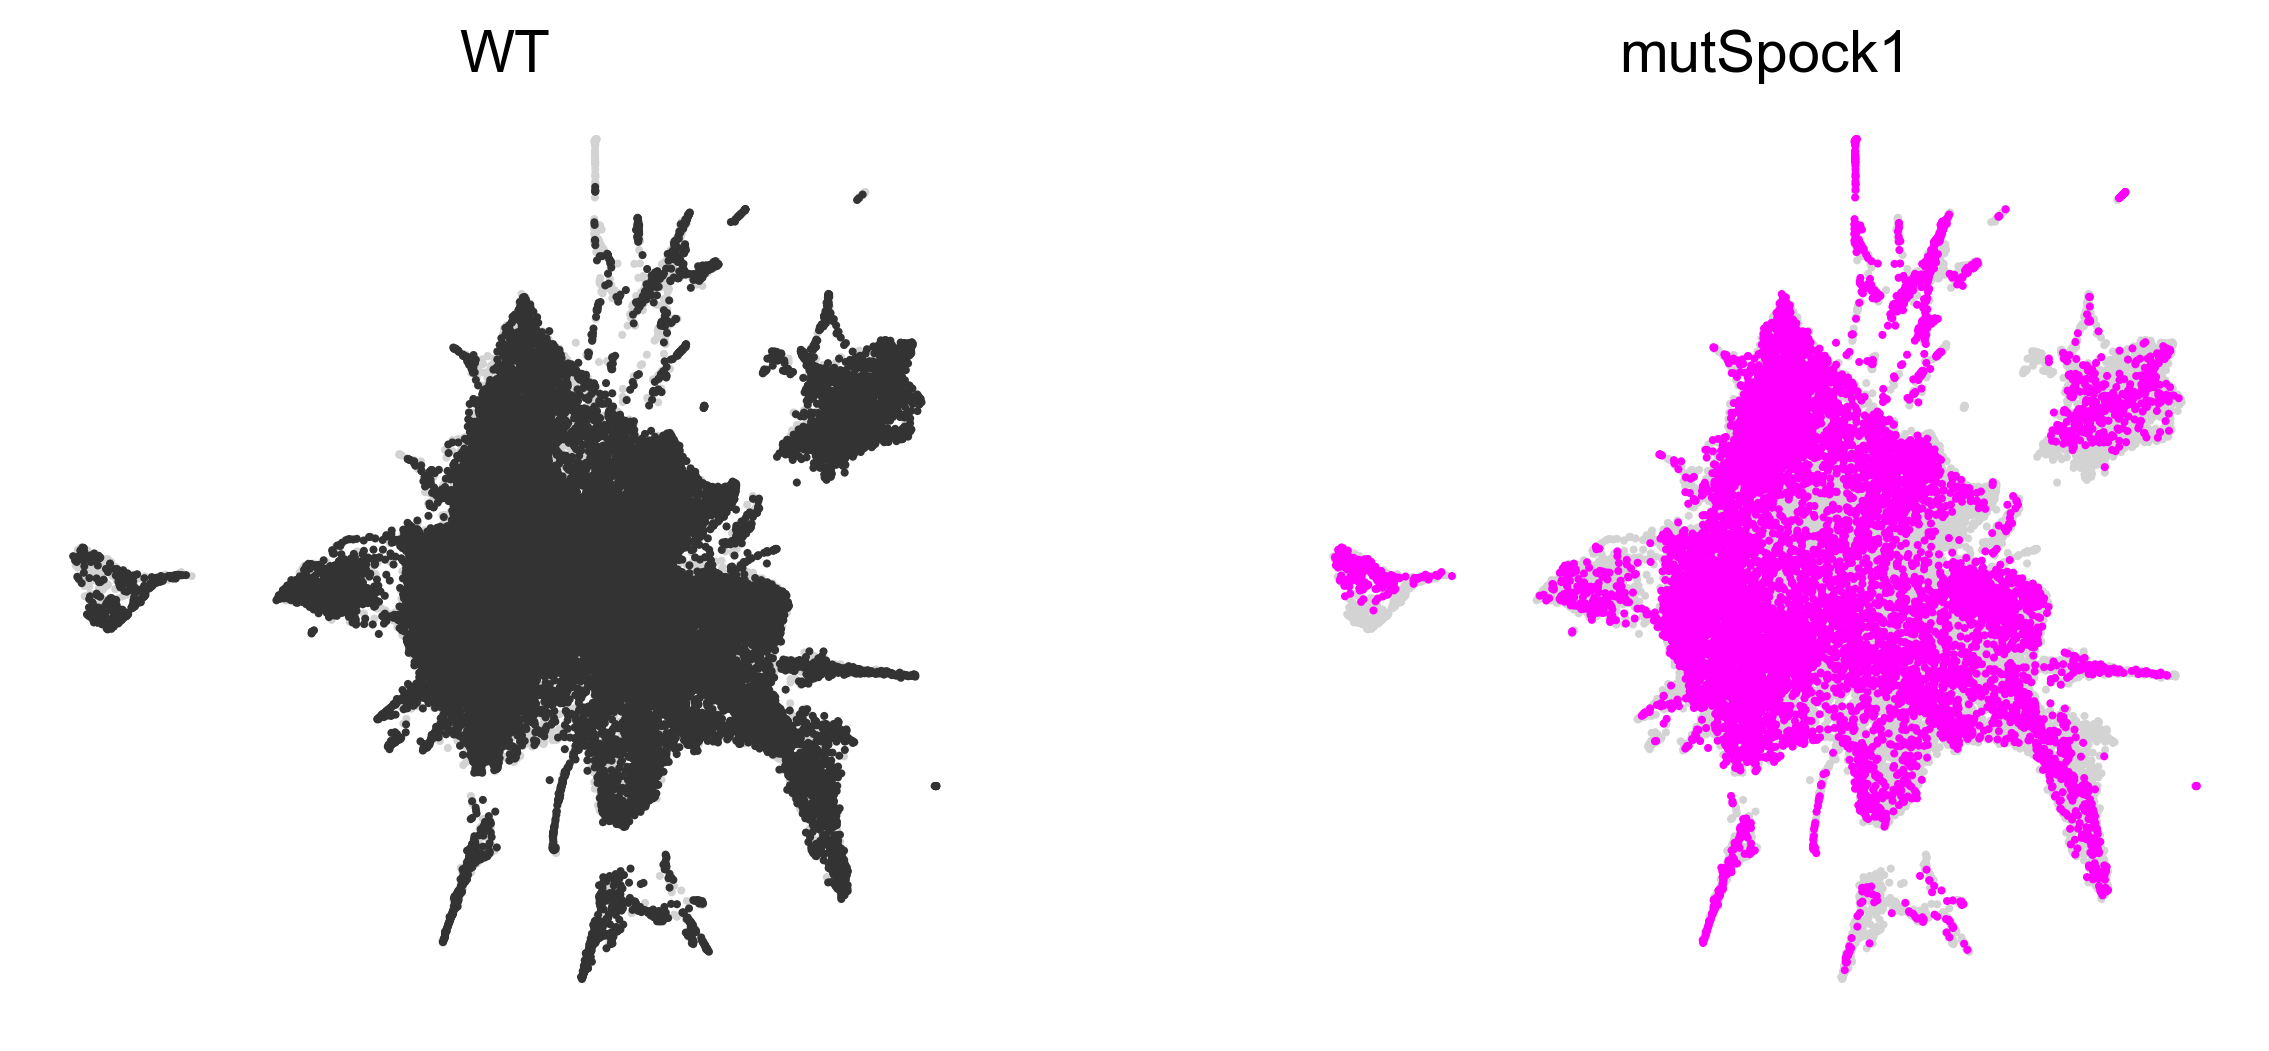

In [30]:
cluster_small_multiples(adata, 'genotype_comb', size=15, save='_Filtered_genotype_separate.pdf')

## Perform Differential Gene Experssion analysis by Genotype and Leiden Cluster

In [31]:
# Rank sum test function

def get_dge(ad, mask1, mask2, min_frac_expr=0.05, pseudocount=1):
    import statsmodels.sandbox.stats.multicomp
    import scipy.stats
    
    gene_mask = ((ad.X[mask1,:]>0).sum(0).A.squeeze()/mask1.sum() > min_frac_expr) | ((ad.X[mask2,:]>0).sum(0).A.squeeze()/mask2.sum() > min_frac_expr)
    print(sum(gene_mask))
    
    E1 = ad.X[mask1,:][:,gene_mask].toarray()
    E2 = ad.X[mask2,:][:,gene_mask].toarray()
    
    m1 = E1.mean(0) + pseudocount
    m2 = E2.mean(0) + pseudocount
    r = np.log2(m1 / m2)
    
    pv = np.zeros(gene_mask.sum())
    for ii,iG in enumerate(np.nonzero(gene_mask)[0]):
        pv[ii] = scipy.stats.ranksums(E1[:,ii], E2[:,ii])[1]
    pv = statsmodels.sandbox.stats.multicomp.multipletests(pv, alpha=0.05, method='fdr_bh',)[1]
    
    df = pd.DataFrame({
        'gene': ad.var_names.values.astype(str)[gene_mask],
        'p-value': pv,
        'm1': m1 - pseudocount, 
        'm2': m2 - pseudocount, 
        'ratio': r
    })
    
    return df

In [32]:
# Treat RNF and AB as single genotype
mask = adata.obs['genotype']=='RNF'
adata.obs.loc[mask,'genotype']='AB'
adata.obs['genotype'].unique()

['mutSpock1', 'AB']
Categories (3, object): ['AB', 'RNF', 'mutSpock1']

In [33]:
# Prepare clusters to loop over
adata.obs['leiden']=adata.obs['leiden'].astype(str)

leiden_vals = adata.obs['leiden'].unique()

In [34]:
leiden_vals

array(['0', '8', '4', '20', '16', '2', '1', '7', '6', '12', '3', '10',
       '9', '15', '25', '11', '5', '22', '14', '21', '13', '19', '18',
       '17', '26', '28', '24', '29', '23', '27'], dtype=object)

In [35]:
# For each cluster, perform rank sum test
# Minimum expression 5% Cells
# Threshold of 2 average transcripts
# Absolute fold change > 2
# Export to excel


# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('DGE_Output_final/DGE_genes_per_leiden.xlsx', engine='xlsxwriter')


for i in leiden_vals:
    cluster = str(i)
    
    # Mask cells to compare
    mask1 = (adata.obs['genotype']=='mutSpock1') & (adata.obs['leiden']==cluster)
    mask2 = (adata.obs['genotype']=='AB') & (adata.obs['leiden']==cluster)
    
    # DGE Analysis
    df = get_dge(adata,mask1,mask2)
    
    # Thresholding Genes
    threshold = ((df.m1>10) | (df.m2>10)) & (abs(df.ratio)>1)
    df = df[threshold]

    df = df.rename(columns={'m1': 'hm41 (CP10K)', 'm2': 'WT (CP10K)', 'ratio': 'log2 ratio (pseudocount=1)'})
    
    # Export to worksheet
    df.to_excel(writer, sheet_name='Leiden ' + cluster)

    
# Close the Pandas Excel writer and output the Excel file.
writer.save()

5393
4278
4267
5349
5435
3160
2456
4831
5336
4702
5369
4196
4366
2282
3404
4676
2828
4012
5366
4515
4252
6339
6669
5822
4206
5770
5760
6711
4208
2599
